In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import pandas as pd

from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk
from gpr4im import obs_tools as obs

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Understanding GPR

In this notebook we go through the main code used to run Gaussian Process Regression for foreground removal on HI Intensity Mapping data. For the most important functions, we walk through them step by step and then also show how to call them from the relevant scripts. For just a quick introduction of how to run GPR without as much explanation, please see `Running GPR.ipynb`.

Start by assuming you have a random variable $f$, which can be described as a Gaussian process

$$ f \sim \mathcal{GP}(m,\text{K})\, , $$

such that for each frequency slice, we have

$$ f(\boldsymbol{\nu}) \sim \mathcal{N}(m(\boldsymbol{\nu}), k(\boldsymbol{\nu}, \boldsymbol{\nu}))\, . $$

We assume that our data ($\textbf{d}$) is made up of different components, each of which can be assumed to behave as a Gaussian process. The components are the foregrounds, the HI cosmological signal, and the noise. Our kernel function then becomes

$$ \text{K} = \text{K}_{\rm fg} + \text{K}_{\rm 21} + \text{K}_{\rm n}\, $$

and the mean function $m$ is zero because we subtract the mean from our data. So, if we know what $\text{K}_{\rm fg}$, $\text{K}_{\rm 21}$ and $\text{K}_{\rm n}$ are, we can make a prediction for what the foregrounds look like in our frequency range, using the joint probability distribution

$$ \begin{bmatrix}
    \textbf{d} \\
    \textbf{f}_{\rm fg}
    \end{bmatrix}
    = \mathcal{N} \left(
    \begin{bmatrix}
    0 \\
    0
    \end{bmatrix}, 
    \begin{bmatrix}
    \text{K}_{\rm fg} + \text{K}_{\rm 21} + \text{K}_{\rm n} & \text{K}_{\rm fg} \\
    \text{K}_{\rm fg} & \text{K}_{\rm fg}
    \end{bmatrix}
    \right) \, ,$$
    
where $\textbf{f}_{\rm fg}$ is our foreground prediction, also itself a Gaussian process distributed as 

$$ \textbf{f}_{\rm fg} \sim \mathcal{N}(\text{E}[\textbf{f}_{\rm fg}], \text{cov}[\textbf{f}_{\rm fg}]) \, . $$

The expectation value $\text{E}[\textbf{f}_{\rm fg}]$ of our foreground prediction tells us what the foreground signal probably looks like in our frequency range, and _this is what we want to subtract from our data_. The foreground covariance $\text{cov}[\textbf{f}_{\rm fg}]$ is essentially the error on our foreground fit, and can be used to calculate a bias correction to the residual covariance and power spectrum (see `Bias correction.ipynb`). The residual $\textbf{r}$ (our foreground removed data) is simply

$$ \textbf{r} = \textbf{d} - \text{E}[\textbf{f}_{\rm fg}]\, . $$

## Loading data

First, we load all the raw data ($\textbf{d}$) we need for the analysis:

- Foregrounds (with polarisation)
- HI cosmological signal + instrumental noise

And make sure the data is in $[Nx, Ny, Nz]$ format, where $Nz$ is the line of sight (frequency) direction. Our box has dimensions:
- Nx, Ny, Nz = 256, 256, 285
- Lx, Ly, Lz = 1000, 1000, 924.78 Mpc/$h$

The data is smoothed by a constant telescope beam, which is the largest beam given by the beam size at the highest redshift ($z=0.58$). The central redshift of the data is $z=0.39$.

We also load the frequency range of our data, `freqs`. The data goes from 899MHz to 1183MHz in 1MHz increments.

In [3]:
data = pd.read_pickle('../Data/data.pkl')
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise
HI_noise_data = data.beam.HI_noise
freqs = data.freqs

Now we run PCA foreground cleaning in order to compare these results to GPR:

In [4]:
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=7)[0]

## Running GPR

We start by choosing which kernels we will use for each component in our data. These describe $\text{K}_{\rm fg}$ and $\text{K}_{\rm 21}$, but we've split our foreground kernel into a smooth component and a polarised component since those signals look different: $\text{K}_{\rm fg} = \text{K}_{\rm smooth} + \text{K}_{\rm pol}$:

In [5]:
# kernel for the smooth foreground:
kern_fg_smooth = GPy.kern.RBF(1)
# kernel for the polarised foreground:
kern_fg_pol = GPy.kern.RBF(1)
# add foreground kernels together:
kern_fg = kern_fg_smooth + kern_fg_pol
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)

We want to set priors for the kernels, to make sure the foreground kernels aren't fitting to the HI data and the HI kernel isn't fitting to the foregrounds.
Since larger lengthscales mean "smoother" line of sight functions, we want the lengthscale for the foreground kernels to be large and for the HI kernel to be smaller.
We don't do this for the smooth foreground because for that we are using the Polynomial kernel, which doesn't have a lengthscale parameter.

In [6]:
# setting priors for the smooth foreground kernel:
kern_fg.rbf.variance.constrain_bounded(1000,100000000)
kern_fg.rbf.lengthscale.constrain_bounded(200,10000)
# setting priors for the polarised foreground kernel:
kern_fg.rbf_1.variance.constrain_bounded(0.0001,10)
kern_fg.rbf_1.lengthscale.constrain_bounded(15,500)
# setting priors for the HI kernel:
kern_21.variance.constrain_bounded(0.000001,0.5)
kern_21.lengthscale.constrain_bounded(0.01,15)

reconstraining parameters sum.rbf.variance
reconstraining parameters sum.rbf.lengthscale
reconstraining parameters sum.rbf_1.variance
reconstraining parameters sum.rbf_1.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters Exponential.lengthscale


We now define the total kernel function for our data, which is the foreground kernel ($\text{K}_{\rm fg}$) + the HI kernel ($\text{K}_{21}$):

In [7]:
kern = kern_fg + kern_21

To run GPR, we will need to make a few choices regarding our data. We simplify these choices in our code by assigning specific parameters that control each of them. The parameters you must set for running GPR are:

- `Input`: data cube to be cleaned, in $[Nx,Ny,Nz]$ format where $Nz$ is the frequency direction
- `num_restarts`: how many times to optimise the GPR regression model by restarting the GPR fit
- `NprePCA`: set to 0 if no pre-PCA is desired, otherwise this number is the $N_\text{FG}$ number of components used in a pre-PCA clean of the data
- `noise_data`: input here your noise map in $[Nx,Ny,Nz]$ if you have a reasonable estimate from your data, otherwise set to None and use GPR to try to fit your noise
- `zero_noise`: if True, the noise in your GPR model will be set to zero and fixed. Otherwise it will try to fit to noise in your data, in either the heteroscedastic or non-heteroscedastic case. Set to zero if you want to fit your noise with a separate kernel instead, otherwise you will fit to noise twice
- `heteroscedastic`: if True, runs Heteroscedastic regression model (where the noise variance changes with frequency) (Note: you cannot have noise=False and heteroscedastic=True at the same time, to set noise to zero set heteroscedastic=False too). If False, the noise variance will be assumed to be constant with frequency.
- `invert`: if True, inverts data in the frequency direction

In [8]:
Input = FGwpol_HI_noise_data
num_restarts = 15
NprePCA = 0
noise_data = None
zero_noise = True
heteroscedastic = False
invert = False

Prepare the data $\textbf{d}$ for running GPR:

In [9]:
# extract axes from the data:
axes = np.shape(Input)
    
# if desired, do a pre-PCA with N_FG=NprePCA removed components
if NprePCA > 0: Input = fg.PCAclean(Input, N_FG=NprePCA)[0]

# converting data format to LoS pixels [Nx,Ny,Nz] -> [Npix,Nz]
Input = obs.LoSpixels(Input)
if noise_data is not None: noise_data = obs.LoSpixels(noise_data)

# invert frequency axis
if invert==True: 
    Input = Input[::-1]
    if noise_data is not None: noise_data = noise_data[::-1]

Next, we build our GPR model using our frequency rance, input data and kernel. This will look different depending on the choices made for the parameters, e.g. whether the noise is fixed and whether the model is heteroscedastic (these choices will describe $\text{K}_{\rm n}$).

In [10]:
# this heteroscedastic case assumes a Gaussian noise variance that changes with frequency
if heteroscedastic==True: 
    # this case assumes noise is known, sets noise level to your noise_data variances
        # at different frequencies (since heteroscedastic)
    if noise_data is not None:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
        model.het_Gauss.variance.constrain_fixed(noise_data.var(axis=1)[:, None])
    # this case assumes noise is not known, model will fit a variance at each frequency
    else:
        model = GPy.models.GPHeteroscedasticRegression(freqs[:, np.newaxis], Input, kern)
    # note: if you want the case of *no noise*, there's no need to use heteroscedastic,
        # so set heteroscedastic = False and see below

# this non-heteroscedastic case assumes constant Gaussian noise variance throughout frequency
else: 
    # this case assumes noise is know, sets the noise variance level to the variance
        # from the input noise_data
    if noise_data is not None:
        model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
        model.Gaussian_noise.constrain_fixed(noise_data.var())
    else:
        # this case assumes there is no noise in your data
        if zero_noise == True:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
            model['.*Gaussian_noise'] = 0.0
            model['.*noise'].fix()
        # this case assumes there is noise but it is unknown, fits a constant variance
        else:
            model = GPy.models.GPRegression(freqs[:, np.newaxis], Input, kern)
            

Now that we have the model, we optimise it and find the best fitting hyperparameters for the kernels:

In [11]:
model.optimize_restarts(num_restarts = num_restarts)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/15, f = -46274836.77963373
Optimization restart 2/15, f = -46274836.47289043
Optimization restart 3/15, f = -45836972.70681715
Optimization restart 4/15, f = -46274837.07699615
Optimization restart 5/15, f = -45912076.25855819
Optimization restart 6/15, f = -45011355.18862319
Optimization restart 7/15, f = -46274836.95825101
Optimization restart 8/15, f = -46223468.06620511
Optimization restart 9/15, f = -46223405.88447382
Optimization restart 10/15, f = -46274836.54936474
Optimization restart 11/15, f = -46274836.44858438
Optimization restart 12/15, f = -46274836.84219202
Optimization restart 13/15, f = -45910415.56249237
Optimization restart 14/15, f = -46274836.85977705
Optimization restart 15/15, f = -46274836.83931525


We can print the optimised model to see things such as the objective function (which we want to be as small as possible), and also the best fit hyperparameters for the kernels. The `Objective` parameter describes how good of a fit our model is, and we want this to be as small as possible (i.e., a large negative number). You can extract the objective value directly from the model by printing: `model.objective_function()`. The `Objective` is the negative marginal likelihood, hence whi minimizing this maximizes the likelihood. You can check this by also printing `model.log_likelihood()` and checking that it is the negative of `model.objective_function()`.

Note that GPR is a stochastic process, so you can expect results to vary slightly each time (though if it is varying substantially everytime, it's likely due to the model not yet converging, so try a larger `num_restarts`).

In [12]:
model

GP_regression.,value,constraints,priors
sum.rbf.variance,67201.27626918537,"1000.0,100000000.0",
sum.rbf.lengthscale,475.356162994789,"200.0,10000.0",
sum.rbf_1.variance,0.498987505437131,"0.0001,10.0",
sum.rbf_1.lengthscale,58.412803420773,"15.0,500.0",
sum.Exponential.variance,0.0012140391227348113,"1e-06,0.5",
sum.Exponential.lengthscale,6.723193185227804,"0.01,15.0",
Gaussian_noise.variance,0.0,+ve fixed,


Now that we have the optimised model for $\text{K}$, we can use the best fit hyperparamers found for the foreground kernels and use it to "predict" a sample of the foregrounds in our frequency range, and then subtract that prediction from our input data. This is the process of foreground removal with GPR, and should leave us with an estimate for the HI cosmological signal and noise. It uses our data $\textbf{d}$ and best fit kernel $\text{K}$ to find the prediction for the foregrounds in our frequency range ($\textbf{f}_{\rm fg}$), using the joint probability distribution:

$$ \begin{bmatrix}
    \textbf{d} \\
    \textbf{f}_{\rm fg}
    \end{bmatrix}
    = \mathcal{N} \left(
    \begin{bmatrix}
    0 \\
    0
    \end{bmatrix}, 
    \begin{bmatrix}
    \text{K}_{\rm fg} + \text{K}_{\rm 21} + \text{K}_{\rm n} & \text{K}_{\rm fg} \\
    \text{K}_{\rm fg} & \text{K}_{\rm fg}
    \end{bmatrix}
    \right) \, ,$$
    
and it finds the best predictions for $\text{E}[\textbf{f}_{\rm fg}]$ and $\text{cov}[\textbf{f}_{\rm fg}]$.

In [13]:
# extract the optimised foreground kernel from our model:
if kern_fg.name == 'sum': # if there is more than one foreground kernel
    k_fg_length = len(kern_fg.parts)
    k_fg = model.kern.parts[0]
    if k_fg_length > 1:
        for i in range(1, k_fg_length):
            k_fg += model.kern.parts[i]
else: k_fg = model.kern.parts[0] # if there is only one foreground kernel

# make prediction of what the FGs would look like using this optimised FG kernel:
fg_fit, fg_cov = model.predict(freqs[:, np.newaxis], full_cov=True, kern=k_fg,
    include_likelihood=False)

# subtract the expected FG from data, to obtain the HI+noise residual:
gpr_res = Input - fg_fit

# un-invert data:
if invert==True: 
    gpr_res = gpr_res[::-1]
    fg_fit = fg_fit[::-1]
    
# reshape residuals back to [Nx, Ny, Nz]
gpr_res = np.swapaxes(gpr_res,0,1)
gpr_res = np.reshape(gpr_res,(axes[0], axes[1], axes[2]))

# also reshape foreground fit back to [Nx, Ny, Nz]
fg_fit = np.swapaxes(fg_fit,0,1)
fg_fit = np.reshape(fg_fit,(axes[0], axes[1], axes[2]))

# create Series as the output object, containing all the important results
d = {'res': gpr_res, 'fgcov': fg_cov, 'fgfit': fg_fit, 'model': model}
gpr_result = pd.Series(d)

The results are:

- `fg_fit` is the expectation value for the foreground prediction in our frequency range ($\text{E}[\textbf{f}_{\rm fg}]$)
- `fg_cov` is the covariance (uncertainty) of our foreground fit ($\text{cov}[\textbf{f}_{\rm fg}]$)
- `gpr_res` is the residual data ($\textbf{r}$), which should contain our HI signal and the noise

We plot below our foreground cleaned map, vs. the true HI map to highlight the effects of foreground removal. Only one redshift (frequency) slice is shown. It is clear from these maps that some power is being lost in the foreground removal step.

Text(0.5, 1.0, 'Foreground removed HI + noise')

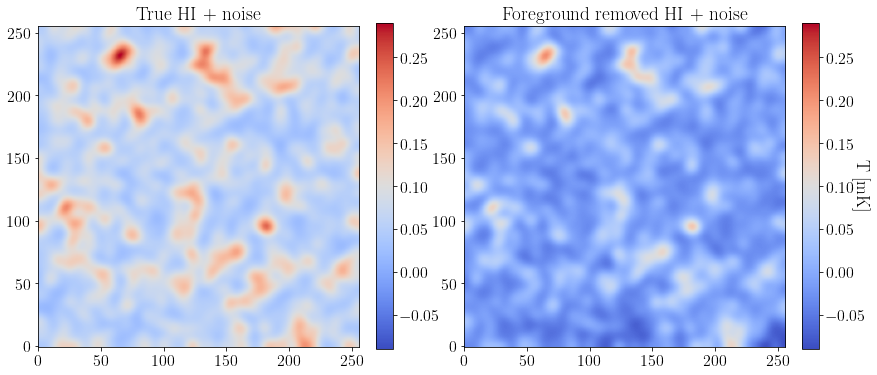

In [16]:
plt.figure(figsize=(14,6))

plt.subplot(121)
pos = plt.imshow(HI_noise_data[:,:,100], origin = 'lower', vmin = -0.09, vmax = 0.29, cmap='coolwarm')
plt.colorbar(pos, fraction=0.046)
plt.title('True HI + noise')

plt.subplot(122)
pos = plt.imshow(gpr_result.res[:,:,100], origin = 'lower', vmin = -0.09, vmax = 0.29, cmap='coolwarm')
cbar = plt.colorbar(pos, fraction=0.046)
cbar.ax.set_ylabel(r'T [mK]', rotation=270, fontsize=18)

plt.title('Foreground removed HI + noise')

Let's try to understand this a bit better. Here, what we did was generate a sample of what the foregrounds look like given the best fitting foreground kernel (expectation value, `fg_fit`), and then subtracted this prediction to obtain the residual, which should contain the HI cosmological signal and the noise. We also, while calculating the expectation value, calculated the covariance (`fg_cov`), which can be thought of as the "error" on the expectation value, given by the fact that the kernel isn't a perfect fit to our data.

We use a bias correction to account for the error in our foreground fit. See the notebook `bias_correction.ipynb` for more details on that. We do this when we calculate the power spectrum of the GPR residual, by calling the function `get_biascorr`.

---

And that's how you run foreground removal with GPR! This can all be done by calling a single function, `GPRclean`, from the script `fg_tools`, which we imported as `fg`. Below shows how this can be done. Recall the parameters we chose:

In [17]:
##### Choose parameters for performing GPR #####

Input = FGwpol_HI_noise_data
num_restarts = 15
NprePCA = 0
noise_data = None
zero_noise = True
heteroscedastic = False
invert = False

##### Choose kernels to describe your data #####

# kernel for the smooth foreground:
kern_fg_smooth = GPy.kern.RBF(1)
# kernel for the polarised foreground:
kern_fg_pol = GPy.kern.RBF(1)
# add foreground kernels together:
kern_fg = kern_fg_smooth + kern_fg_pol
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)

##### Put prior constraints of your kernels #####

# setting priors for the smooth foreground kernel:
kern_fg.rbf.variance.constrain_bounded(1000,100000000)
kern_fg.rbf.lengthscale.constrain_bounded(200,10000)
# setting priors for the polarised foreground kernel:
kern_fg.rbf_1.variance.constrain_bounded(0.0001,10)
kern_fg.rbf_1.lengthscale.constrain_bounded(15,500)
# setting priors for the HI kernel:
kern_21.variance.constrain_bounded(0.000001,0.5)
kern_21.lengthscale.constrain_bounded(0.01,15)

reconstraining parameters sum.rbf.variance
reconstraining parameters sum.rbf.lengthscale
reconstraining parameters sum.rbf_1.variance
reconstraining parameters sum.rbf_1.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters Exponential.lengthscale


Calling the `GPRclean` function:

In [18]:
gpr_result2 = fg.GPRclean(Input, freqs, kern_fg, kern_21, NprePCA=NprePCA,
                                          noise_data=noise_data, heteroscedastic=heteroscedastic, 
                                          zero_noise=zero_noise, invert=invert)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -46274836.98090039
Optimization restart 2/10, f = -46274836.94442012
Optimization restart 3/10, f = -46274836.90972478
Optimization restart 4/10, f = -46274836.47524202
Optimization restart 5/10, f = -46036751.15226153
Optimization restart 6/10, f = -45836974.31308752
Optimization restart 7/10, f = -45900052.47864149
Optimization restart 8/10, f = -46187453.33230139
Optimization restart 9/10, f = -46223457.91831581
Optimization restart 10/10, f = -46274836.57725637


In [19]:
gpr_result2.model

GP_regression.,value,constraints,priors
sum.rbf.variance,67144.60529942486,"1000.0,100000000.0",
sum.rbf.lengthscale,475.24982135911335,"200.0,10000.0",
sum.rbf_1.variance,0.4992373215467187,"0.0001,10.0",
sum.rbf_1.lengthscale,58.41563928041853,"15.0,500.0",
sum.Exponential.variance,0.001214310619295477,"1e-06,0.5",
sum.Exponential.lengthscale,6.724997852937624,"0.01,15.0",
Gaussian_noise.variance,0.0,+ve fixed,


To summarise the outputs again:

- `gpr_result2.res`: residual map of HI and noise, after GPR foreground subtraction;
- `gpr_result2.fgfit`: GPR's prediction for what our foregrounds look like, i.e. what we subtract from our original data to get `res`;
- `gpr_result2.fgcov`: error covariance of the foreground estimate, i.e. how uncertain the estimate of the foreground is;
- `gpr_result2.model`: summary of what the best fit hyperparameters were found for the kernels, and what the objective function is.

If you want, you can print the model again to make sure it's similar to the first model. We plot the power spectra of both `gpr_result.res` and `gpr_result2.res` below to show that they are consistent.

## Plot power spectrum

In [20]:
# Grid dimension of data cube:
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
nx,ny,nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))
# minimum and maximum k in each direction:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1
# set width of k bins to be 2*kmin
dk = 2*kmin
# number of k bins:
nkbin = int((kmax-kmin)/dk)
# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
# setting array of k bin centers"
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)

Calculate bias correction to the 3D power spectrum only:

In [21]:
n_samples = 10
pk_corr = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, kbins, kbins, w, W)[0]
pk_corr2 = pk.get_biascorr(gpr_result2.fgcov, Input, n_samples, lx, ly, lz, kbins, kbins, w, W)[0]

Calculate spherically averaged power spectra:

In [22]:
pk_HI = pk.getpk(HI_noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_GPR = pk.getpk(gpr_result.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] + pk_corr
pk_GPR2 = pk.getpk(gpr_result2.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] + pk_corr2
pk_PCA3 = pk.getpk(pca_res_7,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Text(0.5, 0, '$k$ [$h$/Mpc]')

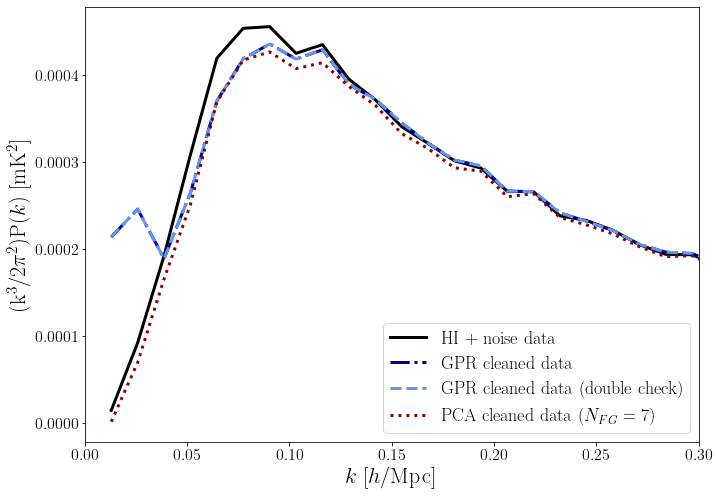

In [23]:
plt.figure(figsize=(11,8))

plt.plot(k, (k*k*k*pk_HI)/(2*np.pi*np.pi), ls='solid', lw=3, c='k', label = r'HI + noise data')
plt.plot(k, (k*k*k*pk_GPR)/(2*np.pi*np.pi), ls='dashdot', lw=3, c='darkblue', label = r'GPR cleaned data')
plt.plot(k, (k*k*k*pk_GPR2)/(2*np.pi*np.pi), ls='dashed', lw=3, c='cornflowerblue', label = r'GPR cleaned data (double check)')
plt.plot(k, (k*k*k*pk_PCA3)/(2*np.pi*np.pi), ls='dotted', lw=3, c='darkred', label = r'PCA cleaned data ($N_{FG}=7$)')

plt.legend(fontsize=18)
plt.xlim(0,0.3)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)
plt.xlabel('$k$ [$h$/Mpc]', fontsize=22)